In [ ]:
#| default_exp optimal_dispatch

In [ ]:
#| export
import pandas as pd

from energy_storage.data import *

In [ ]:
#| hide
from nbdev.showdoc import *

## 1. Introduction

Electricity is sold on the day-ahead market. Sellers and buyers submit their bids for the coming day before noon on a given day. A seller of electricity sells energy for each hour of the next day and receives a compensation for that based on the day-ahead (spot) price of that given day. If there's a mismatch between the amount of electricity that the seller sold and what the seller actually delivered, then the seller receives or pays a compensation based on the imbalance price. The seller receives a compensation if the seller produced more energy than what was sold and pays a compensation in case more energy was sold than delivered.

Traditional power plants are controllable (to different degrees) whereas photovoltaïc (and wind) assets are mostly dependent on weather conditions (and therefore uncontrollable). This uncontrollability can bring significant uncertainty to the revenue of these renewable assets. 

In case of photovoltaïc plants, there are two main issues contributing to financial risk. First, many European countries now have a significant portion of their total energy production sourced from photovoltaïc assets (>10%). As a result, moments of high photovoltaïc energy production increasingly result in downward pressure on the day-ahead prices due to higher energy supply resulting in lower revenues. Second, renewable energy, unlike traditional power plants, are mostly uncontrollable since energy production is driven by weather conditions. Because of this, estimating the energy to be sold on the day-ahead market has higher risks of large imbalance costs, since production is driven by uncontrollable factors and therefore has to be forecasted.

One solution to potentially reduce the finanical risks from the two before-mentioned issues is to combine photovoltaïc assets with energy storage solutions to have more control on when energy is dispatched to the electricity grid. Energy storage could mitigate the risk of the lower prices on hours of high production by dispatching the energy to the grid on hours with higher prices. Batteries could as well mititage some of the incurred imbalance costs by rebalancing the energy returned to the grid such that the sold energy at each hour more closely matches the actual energy returned to the grid.

In Section 2, we will discuss how batteries could help with dispatching energy to the grid to sell this energy at higher prices. In Section 3, we introduce an extension to the analysis in Section 2 by investigating the higher inherit imbalance risks for photovoltaïc assets.

## 2. Optimal Energy Dispatching using Battery Storage

Before trying to optimise revenues, let's start by defining what the revenue is supposed to look like. For any given day, let $P_t$ be the day-ahead price in €/kWh at hour $t$ and $V_t$ the ingested production in kW at time $t$. The revenue is then defined as:

$$
    R = \sum_{t=0}^{23} P_t V_t
$$

The main observation here is that we have some control over $V_t$ so that we can try to ingest energy to the grid at hours with higher prices. 

### Day-ahead prices

The next figure shows the normalised prices over the last two years together:

In [ ]:
df_price = get_spot_price() / 1000. # prices in €/kWh instead of €/GWh

<AxesSubplot:>

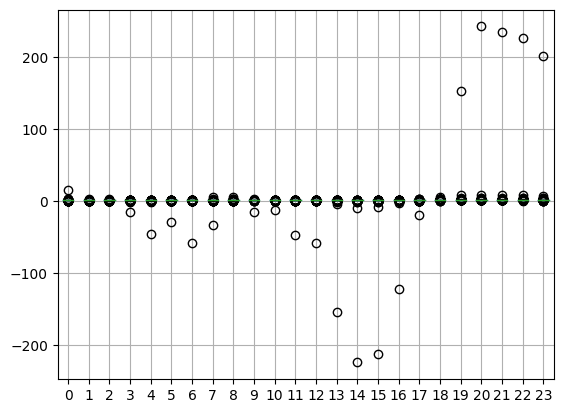

In [ ]:
df_price_normal = df_price.groupby(pd.Grouper(freq="1d")).apply(lambda d: d / d.mean())

# create wide for boxplot and remove duplicate date, hour tuples due to change to winter time
df_price_normal = df_price_normal.to_frame().assign(hour=lambda d: d.index.hour, date=lambda d: d.index.date)
df_price_normal = df_price_normal[~df_price_normal[["hour", "date"]].duplicated()]

df_price_normal.pivot(index="date", columns="hour", values="spot_price").boxplot()

It's hard to get a good sense of the daily distribution since we have a few hours with extremely large values -- 200 means that the price is 200 times higher than the average of that day! However, note that extremely low prices happen around noon whereas the extremely high prices happen during during the evening.

The following boxplot contains the same data without prices that are 10 times higher/lower than the average price

<AxesSubplot:>

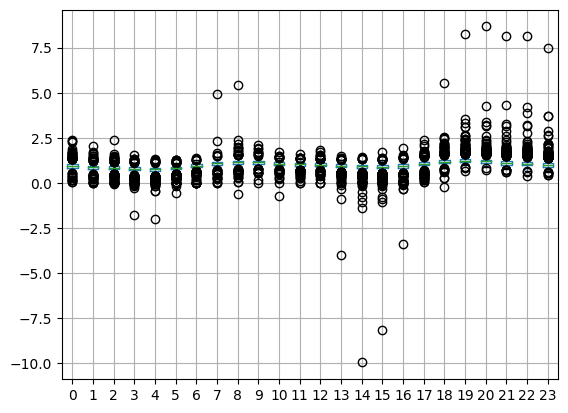

In [ ]:
df_price_normal[df_price_normal["spot_price"].abs() < 10].pivot(index="date", columns="hour", values="spot_price").boxplot()

Unsurprisingly, electrictrity prices are higher at hours of high demand (morning and evening) and lower during off-peak hours (afternoon and night). Another reason for relatively low prices during the afternoon is because photovoltaïc plants produce the most during the afternoon.

### Production

The hourly distribution of our photovoltaïc plant looks as follows:

<AxesSubplot:>

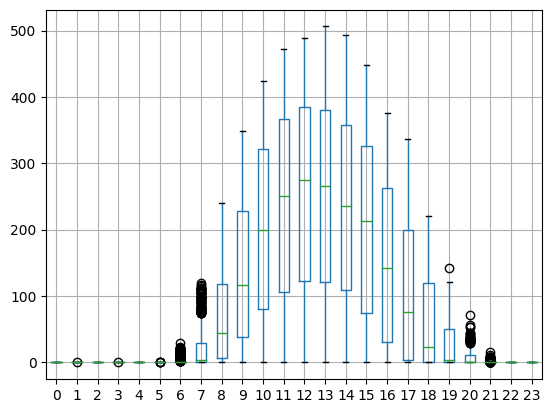

In [ ]:
df_prod = get_production()

df_prod_help = df_prod.to_frame("prod").assign(hour=lambda d: d.index.hour, date=lambda d: d.index.date)
df_prod_help = df_prod_help.loc[~df_prod_help[["date", "hour"]].duplicated()]


df_prod_help.pivot(index="date", columns="hour", values="prod").boxplot()

### On-peak vs. Local Revenue

To get an indication of the "lost" revenue due to producing energy at hours with low prices (afternoon) we can compare the on-peak revenue with the local revenue. We define the on-peak volume as the local volume but redistributed over the on-peak hours. For this we define a simple helper function to redistribute the volume:

In [ ]:
#| export
def redistribute_daily_production(
    df: pd.Series,                 # production data
    daily_distribution: list[str]  # distribution at each our
) -> pd.DataFrame:
    if len(daily_distribution) != 24:
        raise ValueError("Daily distribution needs a value for each hour.")
    
    df_hour = pd.DataFrame(data={"distribution": daily_distribution, "hour": list(range(24))})
    df_hour["distribution"] /= df_hour["distribution"].sum()
    return (
        df
        .to_frame("prod")
        .assign(hour=lambda d: d.index.hour)
        .reset_index()
        .merge(df_hour, how="left", on="hour")
        .set_index("time")
        .groupby(pd.Grouper(freq="1d"))
        .apply(lambda d: d["distribution"] * d["prod"].sum())
    )


In [ ]:
onpeak_dist = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]

df_prod_onpeak = redistribute_daily_production(df_prod, daily_distribution=onpeak_dist)


**Local price**:

In [ ]:
df_revenue = df_price.to_frame().merge(df_prod, left_index=True, right_index=True).assign(revenue=lambda d: d["prod"] * d["spot_price"])
df_price_local = df_revenue.groupby(pd.Grouper(freq="MS")).apply(lambda d: d["revenue"].sum() / d["prod"].sum())

Let's compare the local and the baseload price...